# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [ ]:
# Load the libraries
import pandas as pd
import numpy as np
import os
import shap
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [18]:
%load_ext dotenv
%dotenv 
%run update_path.py

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [19]:
os.getenv('forestfires')

In [20]:
from glob import glob
glob(os.path.join(os.getenv('SRC_DIR'), "data/fires/forestfires/*.csv"))

['../../05_src/data/fires/forestfires\\forestfires.csv']

In [21]:
fires_df = pd.read_csv(r'C:/Users/amena/DSI/production/05_src/data/fires/forestfires\\forestfires.csv')
fires_df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [ ]:
#  change colums nameand load data 
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_df = (pd.read_csv(r'C:/Users/amena/DSI/production/05_src/data/fires/forestfires\\forestfires.csv', header = 0, names = columns))
fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [ ]:
# missing value
fires_df.isna().sum() 

coord_x    0
coord_y    0
month      0
day        0
ffmc       0
dmc        0
dc         0
isi        0
temp       0
rh         0
wind       0
rain       0
area       0
dtype: int64

In [75]:
fires_df.describe(include="all")

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
count,517.000000,517.000000,517,517,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
unique,NaN,NaN,12,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,aug,sun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,184,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.669246,4.299807,NaN,NaN,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,NaN,NaN,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,NaN,NaN,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,NaN,NaN,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,NaN,NaN,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,NaN,NaN,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000


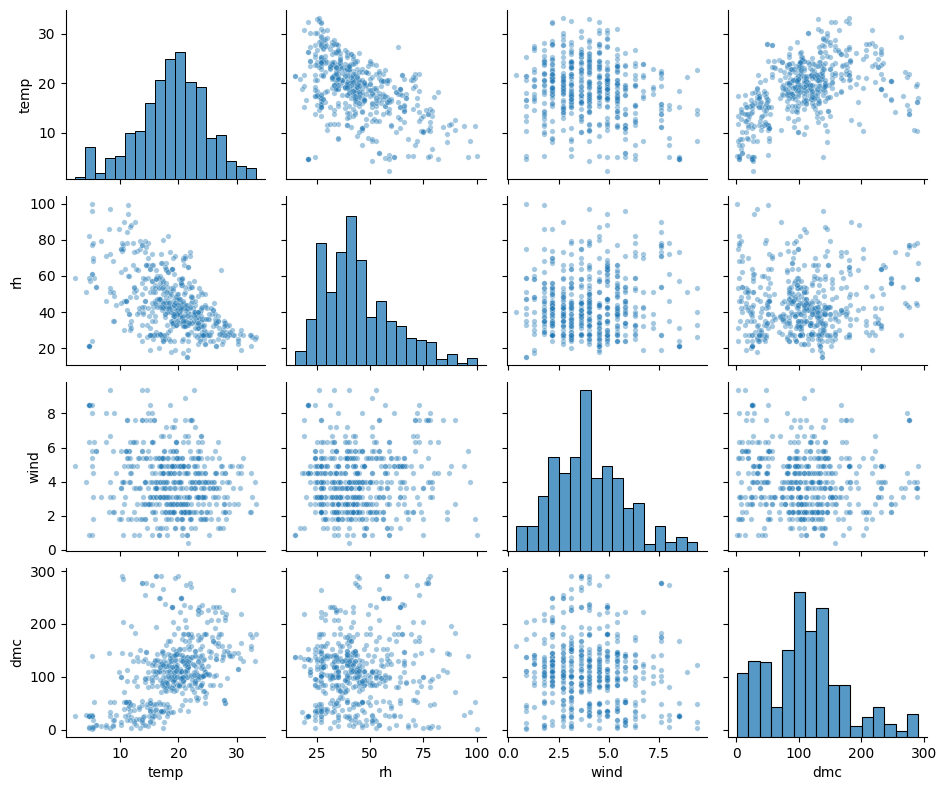

In [76]:
# summary plot of important feathure of prc-2
X = fires_df
num_cols = ["temp", "rh", "wind",'dmc']
sns.pairplot(
    X[num_cols],
    diag_kind="hist",
    plot_kws={"alpha": 0.4, "s": 15},
    height=2.0,
    aspect=1.2
)
plt.show()

# Get X and Y

Create the features data frame and target data.

In [ ]:
# (0) zero values in the area 
zero_count = (fires_df["area"] == 0).sum()
zero_count

np.int64(247)

In [ ]:
df = fires_df
X = df.drop(columns=['area'])
Y = 1*(df[['area']] >=5 ).values.ravel() # 5 heactor area
#Y = df['area']

In [28]:
np.unique(Y, return_counts=True)

(array([0, 1]), array([366, 151]))

In [29]:
X.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [30]:
categ=['month','day']
num_cols =  [
    'coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain' 
]

#preproc1= ColumnTransformer([            
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist'), categ)
], remainder='passthrough')
numeric_features = fires_df.select_dtypes(include="number").columns.tolist()
num_cols = numeric_features

In [ ]:
# REPROCESSOR 1: Simple Scaling 
##---------------------------------------------------------------------
pipe_num_simple= Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), #miissing value 
    ('standardizer', StandardScaler())
])

preproc1 = ColumnTransformer(
    transformers=[
        ('num_transform', pipe_num_simple, num_cols),
        #('cat_transform',OneHotEncoder(handle_unknown='ignore',categories=[list(range(1, 13)),list(range(1, 32))] ),['month', 'day'])
        ('cat_transform', OneHotEncoder(handle_unknown='ignore',drop='first'),['month','day'])],
    remainder='drop'
)


In [77]:

pipe_num_simple= Pipeline([             
    ('preprocess', preproc1),
    ('regressor', Lasso())
])
pipe_num_simple

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_transform', ...), ('cat_transform', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [ ]:
#REPROCESSOR 2:
#num_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

num_cols_tarsform= ['dmc','rh','temp']

pipe_num_simple= Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('standardizer', StandardScaler())
])

pipe_num_yj = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('standardizer', StandardScaler()),
    ('transform', PowerTransformer(method='yeo-johnson'))
])

Preproc2=ColumnTransformer([
        ('numeric_std', pipe_num_simple, num_cols),
        ('numeric_yj', pipe_num_yj, num_cols_tarsform),
        #('num_transform', StandardScaler(), num_cols ),
        ('cat_transform', OneHotEncoder(handle_unknown='ignore',drop='first'),['month','day'])
        #('cat_transform',OneHotEncoder(handle_unknown='ignore',categories=[list(range(1, 13)),list(range(1, 32))] ),['month', 'day'])       
],
remainder='drop')


In [ ]:
# for baselien prc-2
pipe_yj = Pipeline([
    ('preprocess', Preproc2),
    ('regressor', Lasso())
])
pipe_yj

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_std', ...), ('numeric_yj', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [37]:
# Model Pipeline A = preproc1 + baseline
#---------------------------------------------------------
Pipeline_A  = Pipeline([
    ('preprocessing',preproc1),
    ('regressor',KNeighborsRegressor())
])
Pipeline_A

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_transform', ...), ('cat_transform', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [38]:
# Modle Pipeline B = preproc2 + baseline
#-------------------------------------------------------
Pipeline_B =  Pipeline([
    ('preprocessing',Preproc2),
    ('regressor',KNeighborsRegressor())
])
Pipeline_B

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_std', ...), ('numeric_yj', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [39]:
# Model Pipeline C = preproc1 + advanced model
#-------------------------------------------------------
Pipeline_C  = Pipeline([
    ('preprocessing',preproc1),
    ('regressor',RandomForestRegressor(random_state=42))
])
Pipeline_C

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_transform', ...), ('cat_transform', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [40]:
# Model Pipeline D = preproc2 + advanced model
#-------------------------------------------------------
Pipeline_D  = Pipeline([
    ('preprocessing',Preproc2),
    ('regressor',RandomForestRegressor(random_state=42))
])
Pipeline_D

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_std', ...), ('numeric_yj', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [41]:
# Train / test split
#---------------------------------------------

X = df.drop(columns=['area'])
Y = df['area']

#scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error']
#refit_score = 'neg_root_mean_squared_error'

scoring =  ["neg_root_mean_squared_error", "r2"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [42]:
# pipeline parameters
Pipeline_A .get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('num_transform',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardizer',
                                                     StandardScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('cat_transform',
                                    OneHotEncoder(drop='first',
                                                  handle_unknown='ignore'),
                                    ['month', 'day'])])),
  ('regressor', KNeighborsRegressor())],
 'transform_input': None,
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('num_transform',
                                  Pipeline(st

In [43]:
# Hyperparameter tuning  of KNeighborsRegressor
param_grid_A = {
    "regressor__n_neighbors": [5, 10, 20, 30],
    "regressor__weights": ["uniform", "distance"],
    "regressor__metric": ["euclidean", "manhattan"]
}

In [44]:
#Gridsearch
grid_Search_A = GridSearchCV(
    estimator=Pipeline_A, 
    param_grid=param_grid_A, 
    scoring = scoring, 
    cv = 5,
    refit = "neg_root_mean_squared_error" )

grid_Search_A.fit(X_train, Y_train)

c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\p

,estimator,Pipeline(step...Regressor())])
,param_grid,"{'regressor__metric': ['euclidean', 'manhattan'], 'regressor__n_neighbors': [5, 10, ...], 'regressor__weights': ['uniform', 'distance']}"
,scoring,"['neg_root_mean_squared_error', 'r2']"
,n_jobs,None
,refit,'neg_root_mean_squared_error'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num_transform', ...), ('cat_transform', ...)]"


In [45]:
#cross-validated score
best_params_A = grid_Search_A.best_params_
grid_Search_A.best_params_, grid_Search_A.best_score_

({'regressor__metric': 'euclidean',
  'regressor__n_neighbors': 30,
  'regressor__weights': 'uniform'},
 np.float64(-38.412086614965745))

In [46]:
# Predict using best estimator
Y_pred = grid_Search_A.best_estimator_.predict(X_test)
# R² score
r2_A = r2_score(Y_test, Y_pred)
r2_A

-0.00634540641549064

In [47]:
#pipeline parameters
Pipeline_B .get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('numeric_std',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardizer',
                                                     StandardScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('numeric_yj',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardizer',
                                                     StandardScaler()),
                                                    ('transform',
                                           

In [48]:
param_grid_B = {
    "regressor__n_neighbors": [5, 10, 20, 30],
    "regressor__weights": ["uniform", "distance"],
    "regressor__p": [1, 2]  
}

In [49]:
#Gridsearch
grid_Search_B = GridSearchCV(
    estimator=Pipeline_B, 
    param_grid=param_grid_B, 
    scoring = scoring, 
    cv = 5,
    refit =  "neg_root_mean_squared_error")

grid_Search_B.fit(X_train, Y_train)

c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\p

,estimator,Pipeline(step...Regressor())])
,param_grid,"{'regressor__n_neighbors': [5, 10, ...], 'regressor__p': [1, 2], 'regressor__weights': ['uniform', 'distance']}"
,scoring,"['neg_root_mean_squared_error', 'r2']"
,n_jobs,None
,refit,'neg_root_mean_squared_error'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('numeric_std', ...), ('numeric_yj', ...), ...]"


In [50]:
best_params_B = grid_Search_B.best_params_
grid_Search_B.best_params_, grid_Search_B.best_score_

({'regressor__n_neighbors': 30,
  'regressor__p': 2,
  'regressor__weights': 'uniform'},
 np.float64(-38.67061132128321))

In [51]:
# Predict using best estimator
Y_pred = grid_Search_B.best_estimator_.predict(X_test)
# R² score
r2_B = r2_score(Y_test, Y_pred)

r2_B

-0.004956312942678398

In [52]:
#pipeline parameters-c
Pipeline_C .get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('num_transform',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardizer',
                                                     StandardScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('cat_transform',
                                    OneHotEncoder(drop='first',
                                                  handle_unknown='ignore'),
                                    ['month', 'day'])])),
  ('regressor', RandomForestRegressor(random_state=42))],
 'transform_input': None,
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('num_transform',
                            

In [53]:
##pipeline  parameters-c
param_grid_C = {
    "regressor__n_estimators": [200, 400],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5],
    "regressor__min_samples_leaf": [1, 2]
}

In [54]:
#Gridsearch-c
grid_Search_C = GridSearchCV(
    estimator=Pipeline_C, 
    param_grid=param_grid_C, 
    scoring = scoring, 
    cv = 5,
    refit =  "neg_root_mean_squared_error")

grid_Search_C.fit(X_train, Y_train)

c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\p

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [None, 10, ...], 'regressor__min_samples_leaf': [1, 2], 'regressor__min_samples_split': [2, 5], 'regressor__n_estimators': [200, 400]}"
,scoring,"['neg_root_mean_squared_error', 'r2']"
,n_jobs,None
,refit,'neg_root_mean_squared_error'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num_transform', ...), ('cat_transform', ...)]"


In [55]:
best_params_C = grid_Search_C.best_params_
grid_Search_C.best_params_, grid_Search_C.best_score_

({'regressor__max_depth': None,
  'regressor__min_samples_leaf': 2,
  'regressor__min_samples_split': 5,
  'regressor__n_estimators': 400},
 np.float64(-43.191064244530544))

In [56]:
# Predict using best estimator
Y_pred = grid_Search_C.best_estimator_.predict(X_test)
# R² score
r2_C = r2_score(Y_test, Y_pred)

r2_C

0.01198626323478491

In [57]:
#pipeline parameters -D
Pipeline_D .get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('numeric_std',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardizer',
                                                     StandardScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('numeric_yj',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardizer',
                                                     StandardScaler()),
                                                    ('transform',
                                           

In [58]:
param_grid_D = {
    "regressor__n_estimators": [300, 500],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5],
    "regressor__min_samples_leaf": [1, 2, 5]
}

In [59]:
##Gridsearch-D
grid_Search_D = GridSearchCV(
    estimator=Pipeline_D, 
    param_grid=param_grid_D, 
    scoring = scoring, 
    cv = 5,
    refit =  "neg_root_mean_squared_error")

grid_Search_D.fit(X_train, Y_train)

c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\production\production-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\amena\DSI\p

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [None, 10, ...], 'regressor__min_samples_leaf': [1, 2, ...], 'regressor__min_samples_split': [2, 5], 'regressor__n_estimators': [300, 500]}"
,scoring,"['neg_root_mean_squared_error', 'r2']"
,n_jobs,None
,refit,'neg_root_mean_squared_error'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('numeric_std', ...), ('numeric_yj', ...), ...]"


In [60]:
best_params_D = grid_Search_D.best_params_
grid_Search_D.best_params_, grid_Search_C.best_score_

({'regressor__max_depth': 10,
  'regressor__min_samples_leaf': 5,
  'regressor__min_samples_split': 2,
  'regressor__n_estimators': 500},
 np.float64(-43.191064244530544))

In [61]:
# Predict using best estimator
Y_pred = grid_Search_D.best_estimator_.predict(X_test)
# R² score
r2_C = r2_score(Y_test, Y_pred)
r2_C

-0.0005838371587230107

# Evaluate

+ Which model has the best performance?

In [ ]:
# Evalute model has the best performance
results = []
models = {
    "Model A": grid_Search_A.best_estimator_,
    "Model B": grid_Search_B.best_estimator_,
    "Model C": grid_Search_C.best_estimator_,
    "Model D": grid_Search_D.best_estimator_,
}
for name, model in models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(Y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
    print(f"{name} | R²: {r2:.3f} | RMSE: {rmse:.2f}")
    results.append((name, r2, rmse)) 
results_df = pd.DataFrame(results, columns=["Model", "R2", "RMSE"])

Model A | R²: -0.006 | RMSE: 108.92
Model B | R²: -0.005 | RMSE: 108.84
Model C | R²: 0.012 | RMSE: 107.92
Model D | R²: -0.001 | RMSE: 108.60


In [63]:
best_model = results_df.sort_values("RMSE").iloc[0]
best_model

Model       Model C
R2         0.011986
RMSE     107.918816
Name: 2, dtype: object

Model C (Preproc 1 + RandomForestRegressor) did the best out of the four pipelines, however it had a relatively low R2.
Model C RMSE: 107.92 (Lowest) for metric comparison
Model C R2R2: 0.012 (Highest/Only positive)

Analysis: The Forest Fires dataset is quite hard to predict because the target (area) is very unevenskewed, with a lot of zeros(0) and a few extreme outliers. Model C used a non-linear tree-based method called Random Forest, which was better at handling interactions between features than the K-Nearest Neighbors method used as a baseline. The "Simple Preprocessor" (Preproc 1) probably did better than the Power Transformer (Preproc 2) since the Random Forest doesn't change features in a way that makes them less useful, which makes the Yeo-Johnson phase unnecessary or even a little noisy.

# Export

+ Save the best performing model to a pickle file.

In [64]:
# Export the best overall model
os.makedirs("./Assi_2/jan25/models", exist_ok=True)
with open('./Assi_2/jan25/models/best_model_C.pkl', 'wb') as f:
    pickle.dump(grid_Search_C.best_estimator_, f)

In [65]:
with open('./Assi_2/jan25/models/best_model_C.pkl', 'rb') as f:
 best_model_C = pickle.load(f)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [66]:
best_model_C.named_steps['regressor']

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [67]:
# 1. Get the best trained pipeline (Model C)
best_model_C = grid_Search_C.best_estimator_

In [68]:
# 2. Transform the test data using the trained preprocessing
X_test_trans = best_model_C.named_steps["preprocessing"].transform(X_test)

In [ ]:
# (numeric + one-hot encoded)
feature_names = best_model_C.named_steps["preprocessing"].get_feature_names_out()

clean_feature_names = [
    name.replace("num_transform__", "").replace("cat_transform__", "")
    for name in feature_names
]

In [ ]:
# Random Forest model
rf_model = best_model_C.named_steps["regressor"]

In [ ]:
# subset for SHAP to improve speed and stability
X_shap = X_test_trans[:200]

In [72]:
#  Create SHAP TreeExplainer  for RandomForest
explainer = shap.TreeExplainer(rf_model)

In [ ]:
#  Compute SHAP values 
shap_values = explainer.shap_values(
    X_shap,
    check_additivity=False
)

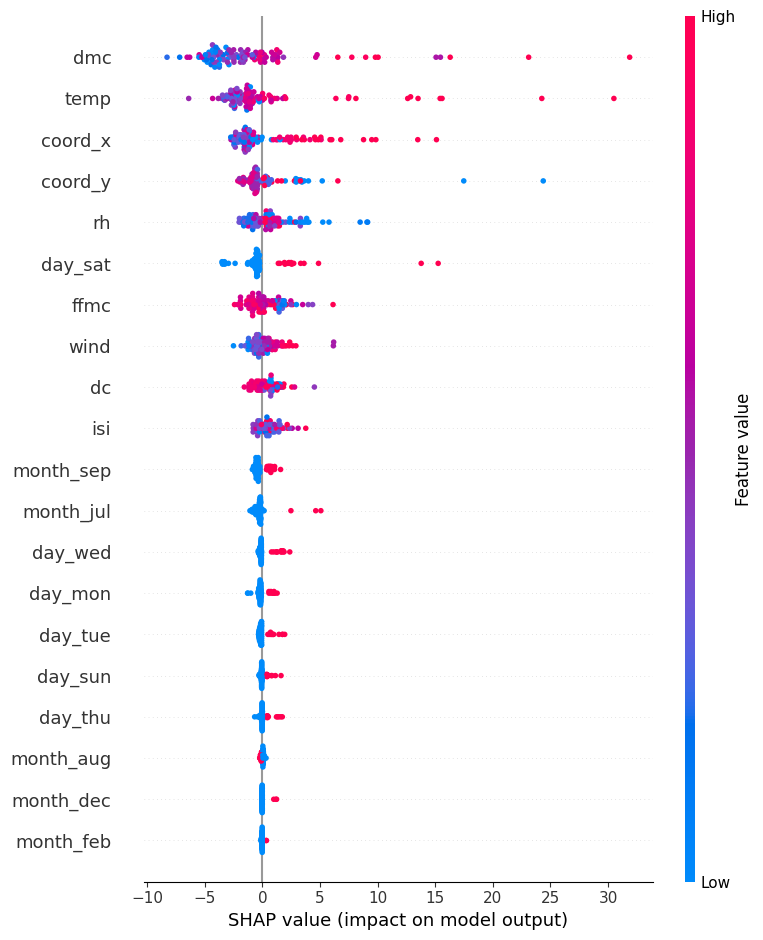

In [ ]:
# Shap summery plot
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=clean_feature_names
)


*(Answer here :
Based on the shap summary :
temp (Temperature): This is usually the best indicator; greater fire regions are linked to higher temperatures.
Relative Humidity (rh): The forest is more likely to catch fire when the humidity is lower.
dmc / dc: These numbers show how moist the fuel is. High values mean that the deep-soil layers are dry, which helps the fire last longer.

Least Important Features: day , Most individual day-of-the-week dummies (such day_mon and day_tue) probably have SHAP values that are close to zero. This means that the specific day of the week doesn't have much of an effect on how quickly the fire spreads.
Rain: It's interesting that rain is so rare in this dataset (mainly 0.0), therefore it often doesn't have much global relevance even though it is important in real life.

features are the most and least important:
I would suggest getting rid of the day of the week features. In the study of forest fires, the day of the week variable that doesn't usually give us more information than the real weather data (temp, wind, rh).  SHAP summary probably demonstrates that most day dummies don't have much of an effectof Fire.

Remove features from the model:
I would recommend removing the day of the week features.
Cross-Validation: Run a 5-fold or 10-fold cross-validation on both.
This dataset is typically better at predicting "Fire vs. No Fire" (Classification- Y = area >= 5) than it is at predicting specific Regression.)*

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.